In [ ]:
man1 <- read.csv("../data/csv/man1.csv", header=F)
sco1 <- read.csv("../data/csv/sco1.csv", header=F)
car1 <- read.csv("../data/csv/car1.csv", header=F)
lon1 <- read.csv("../data/csv/lon1.csv", header=F)
lon2 <- read.csv("../data/csv/lon2.csv", header=F)

suppressWarnings({
    x <-  Reduce(function(...) merge(..., by=1), list(man1, sco1, car1, lon1, lon2))
})
    
names(x) <- c("timestamp", "man1", "sco1", "car1", "lon1", "lon2")
x$timestamp <- as.POSIXct(x$timestamp, origin="1970-01-01", tz="UTC")

x <- x[apply(x[, 2:ncol(x)], 1, prod) != 0, ] # rm any rows with 0
x <- x[x$timestamp >= as.POSIXct("2015-06-15", origin="1970-01-01", tz="UTC"), ] # 5 min intervals from this point+

x$weekday <- weekdays(x$timestamp)
       
head(x)

In [2]:
as.data.frame(table(x$weekday))

Var1,Freq
Friday,36939
Monday,36851
Saturday,36855
Sunday,36566
Thursday,37002
Tuesday,36761
Wednesday,36978


In [3]:
cross_section <- function(x, ixp) {
    df <- 16
    mon <- x[x$weekday == "Monday", ]
    plot(smooth.spline(tapply(mon[, ixp], format(mon$timestamp, "%H%M"), mean), df=df), type="l", col="red", xlab = "t", ylab="bw", main=ixp)
    tue <- x[x$weekday == "Tuesday", ]
    lines(smooth.spline(tapply(tue[, ixp], format(tue$timestamp, "%H%M"), mean), df=df), col="blue")
    wed <- x[x$weekday == "Wednesday", ]
    lines(smooth.spline(tapply(wed[, ixp], format(wed$timestamp, "%H%M"), mean), df=df), col="green")
    thu <- x[x$weekday == "Thursday", ]
    lines(smooth.spline(tapply(thu[, ixp], format(thu$timestamp, "%H%M"), mean), df=df), col="purple")
    fri <- x[x$weekday == "Friday", ]
    lines(smooth.spline(tapply(fri[, ixp], format(fri$timestamp, "%H%M"), mean), df=df), col="black")
    sat <- x[x$weekday == "Saturday", ]
    lines(smooth.spline(tapply(sat[, ixp], format(sat$timestamp, "%H%M"), mean), df=df), col="orange")
    sun <- x[x$weekday == "Sunday", ]
    lines(smooth.spline(tapply(sun[, ixp], format(sun$timestamp, "%H%M"), mean), df=df), col="magenta")
    abline(v=9*12, lty=2)
    abline(v=17*12, lty=2)
}

# london x2,  manchester, scotland, cardiff

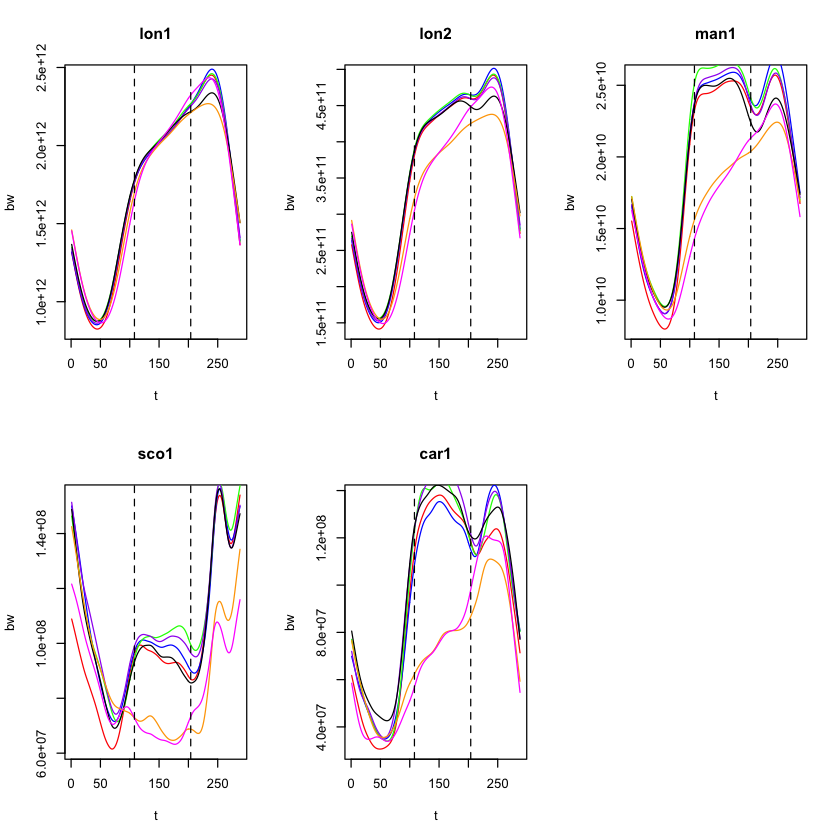

In [4]:
par(mfrow=c(2,3))
cross_section(x, "lon1")
cross_section(x, "lon2")
cross_section(x, "man1")
cross_section(x, "sco1")
cross_section(x, "car1")

In [5]:
norml <- function(x) (x-min(x))/(max(x)-min(x))
x$mew <- rowMeans(apply(x[, -c(1, ncol(x))], 2, norml))

# mean profile / all ixps

* black = friday. lower internet use on friday evenings.
* red = monday. lower use all day. (from weekend?)
* magenta = sunday: crosses over saturday (orange) late afternoon. friday+sat lower because of social activity?
* weeeknds start later than weekdays
* tuesday most use in evening
* wednesday most use in week.
* final peak = evening use
* pre trough commuting/eating etc
* before trough: work day
* friday (black) work day ends earlier

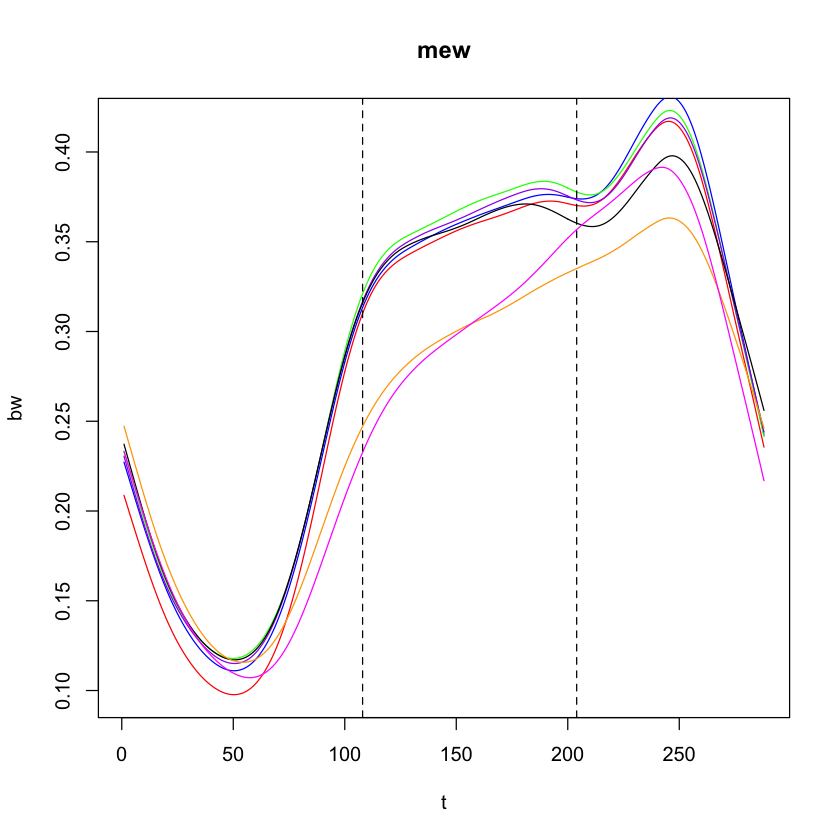

In [6]:
cross_section(x, "mew")

In [7]:
mean_per_day <- tapply(x$man1, as.Date(x$timestamp), mean)
mean_per_day_cross <- as.data.frame(tapply(mean_per_day, weekdays(as.Date(rownames(mean_per_day))), mean))
mean_per_day_cross$weekday <- tolower(substring(rownames(mean_per_day_cross), 0, 3))
mean_per_day_cross <- mean_per_day_cross[order(match(mean_per_day_cross$weekday, c("mon", "tue", "wed", "thu", "fri", "sat", "sun"))), ]
colnames(mean_per_day_cross) <- c("mew", "weekday")
rownames(mean_per_day_cross) <- NULL
mean_per_day_cross


mew,weekday
19579715791,mon
20402795711,tue
20812318577,wed
20233296688,thu
19736097899,fri
16839245827,sat
16591574689,sun


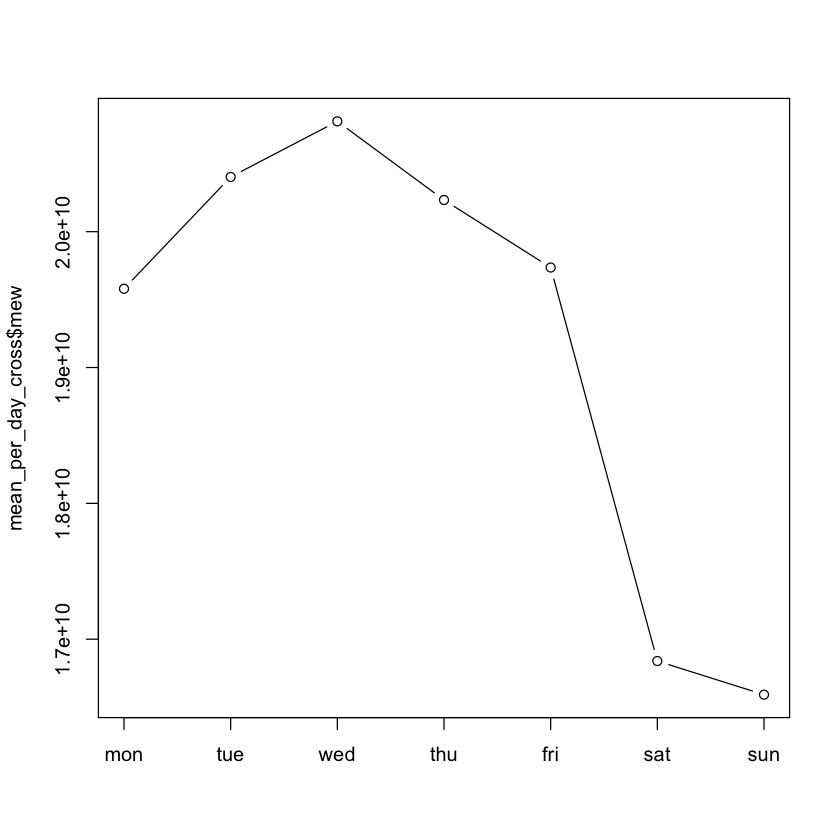

In [8]:
plot(mean_per_day_cross$mew, type="b",xlab = NA, xaxt = "n")
axis(1, at=1:7, labels=mean_per_day_cross$weekday)

In [34]:
mean_per_day <- as.data.frame(mean_per_day)
dates <- as.Date(x$timestamp) # times to dates
mean_per_day$date <- dates[!duplicated(dates)] # 1 date per day
mean_per_day$weekday <- tolower(substring(weekdays(mean_per_day$date), 0, 3))
colnames(mean_per_day) <- c("bandwidth", "date", "day")
rownames(mean_per_day) <- NULL
tail(mean_per_day, 14)
# all work days, 12pm.
#plot(with(x, mew[weekday != "Saturday" & weekday != "Sunday" & format(timestamp, "%H%M") ==  "1200"]), type="l")

,bandwidth,date,day
885,29727511596,2017-11-26,sun
886,37109166801,2017-11-27,mon
887,37564238559,2017-11-28,tue
888,39663900360,2017-11-29,wed
889,40078669145,2017-11-30,thu
890,39884960028,2017-12-01,fri
891,35397122654,2017-12-02,sat
892,34026369709,2017-12-03,sun
893,42472784943,2017-12-04,mon
894,42710299497,2017-12-05,tue


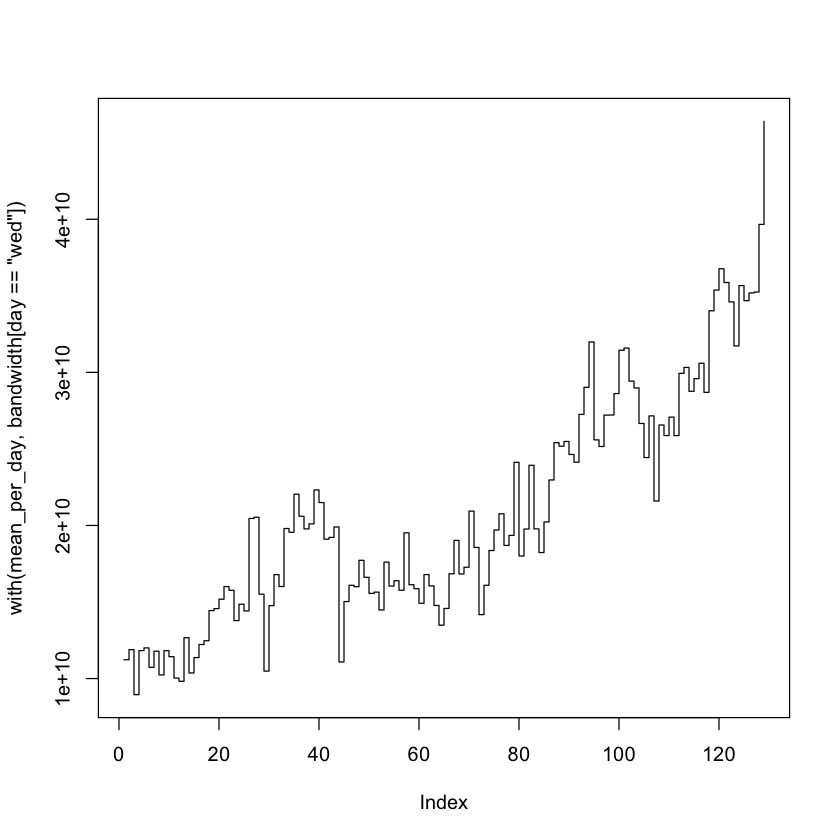

In [43]:
# all manchester mean wednesdays
plot(with(mean_per_day, bandwidth[day == "wed"]), type="s")